In [1]:
# Relevant imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import layers

2024-03-05 16:58:20.047377: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 16:58:23.598005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 16:58:23.602392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 16:58:24.262315: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 16:58:25.562936: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 16:58:25.580129: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Import train + test datasets and split data
train_data = pd.read_csv('/mnt/c/Users/kpali/Documents/ML/Titanic-Kaggle/train.csv')
test_data = pd.read_csv('/mnt/c/Users/kpali/Documents/ML/Titanic-Kaggle/test.csv')
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=1)


In [3]:
# Check number of rows
print('X_train Shape', X_train.shape, sep= ' ')
print('X_valid Shape', X_valid.shape, sep= ' ')

X_train Shape (668, 11)
X_valid Shape (223, 11)


In [4]:
# Counts of nulls per column
print('Null Counts X_train', X_train.isnull().sum(), sep='\n')
print('Null Counts X_valid', X_valid.isnull().sum(), sep='\n')

Null Counts X_train
PassengerId      0
Pclass           0
Name             0
Sex              0
Age            133
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          519
Embarked         1
dtype: int64
Null Counts X_valid
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             44
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          168
Embarked         1
dtype: int64


In [5]:
# Drop Cabin column as it doesn't contain enough useful information
X_train = X_train.drop('Cabin', axis=1)
X_valid = X_valid.drop('Cabin', axis=1)

In [6]:
# Checkout missing Embarked values and see if there are passengers with similar name for imputation
print(X_train[X_train['Embarked'].isnull()])
print(X_train[X_train['Name'].str.contains(r'Stone', regex=True)])
print(X_train[X_train['Name'].str.contains(r'Icard', regex=True)])

     PassengerId  Pclass                                       Name     Sex  \
829          830       1  Stone, Mrs. George Nelson (Martha Evelyn)  female   

      Age  SibSp  Parch  Ticket  Fare Embarked  
829  62.0      0      0  113572  80.0      NaN  
     PassengerId  Pclass                                               Name  \
829          830       1          Stone, Mrs. George Nelson (Martha Evelyn)   
319          320       1  Spedden, Mrs. Frederic Oakley (Margaretta Corn...   

        Sex   Age  SibSp  Parch  Ticket   Fare Embarked  
829  female  62.0      0      0  113572   80.0      NaN  
319  female  40.0      1      1   16966  134.5        C  
Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked]
Index: []


In [7]:
# Drop null values for Embarked column
null_embarked_indexes_train = X_train[X_train['Embarked'].isnull()].index.tolist()
X_train = X_train.drop(null_embarked_indexes_train)
y_train = y_train.drop(null_embarked_indexes_train)
null_embarked_indexes_valid = X_valid[X_valid['Embarked'].isnull()].index.tolist()
X_valid = X_valid.drop(null_embarked_indexes_valid)
y_valid = y_valid.drop(null_embarked_indexes_valid)

count    534.000000
mean      30.013895
std       14.751545
min        0.420000
25%       20.125000
50%       29.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64


<Axes: title={'center': 'Histogram of Age'}, xlabel='Age', ylabel='Frequency'>

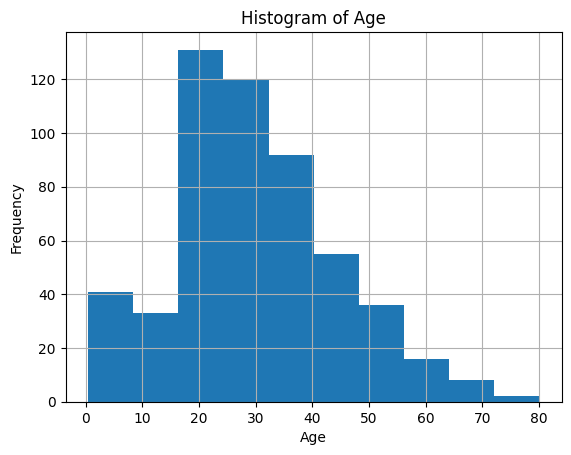

In [8]:
# Age Distribution
print(X_train['Age'].describe())
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
X_train['Age'].hist()

In [9]:
# Impute age
mean_imputation = SimpleImputer(strategy='mean')
age_imputed_train = mean_imputation.fit_transform(X_train[['Age']])
X_train['Age'] = age_imputed_train
age_imputed_valid = mean_imputation.transform(X_valid[['Age']])
X_valid['Age'] = age_imputed_valid

In [10]:
# Check datatypes
X_train.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [11]:
# Compute mutual information score
def calc_mi_scores(X:pd.DataFrame, y:pd.Series):
    le = LabelEncoder()
    X_mi = X.copy()
    for col in X_mi.select_dtypes("object").columns:
        X_mi[col] = le.fit_transform(X_mi[col])
    mi_scores = mutual_info_classif(X_mi,y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

calc_mi_scores(X_train, y_train)

Sex            0.148207
Fare           0.129330
Ticket         0.091240
Pclass         0.051891
Age            0.050727
Parch          0.033894
Embarked       0.028301
SibSp          0.014160
Name           0.001948
PassengerId    0.000000
Name: MI Scores, dtype: float64

In [12]:
# Dropping unimportant features
X_train = X_train.drop(['Name', 'PassengerId', 'Embarked'], axis=1)
X_valid = X_valid.drop(['Name', 'PassengerId', 'Embarked'], axis=1)

In [13]:
# Merge predictors and target into single dataframe
merged_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
merged_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Survived
35,1,male,42.000000,1,0,113789,52.0000,0
46,3,male,30.013895,1,0,370371,15.5000,0
453,1,male,49.000000,1,0,17453,89.1042,1
291,1,female,19.000000,1,0,11967,91.0792,1
748,1,male,19.000000,1,0,113773,53.1000,0


In [14]:
# Generate frequency plot
def generate_frequency_plot(column_name:str):
    frequency = X_train[column_name].value_counts()
    plt.title(f'Frequency by {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Frequency')
    frequency.plot(kind='bar')

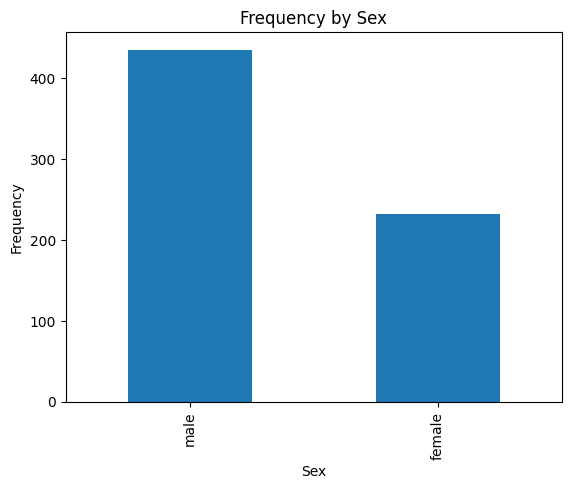

In [15]:
# Exploring Sex
generate_frequency_plot('Sex')

In [16]:
# Calculate survival rates by gender
survival_rate_male = 100.00 * (merged_train[merged_train['Sex'].isin(['male']) & merged_train['Survived'] == 1].shape[0] / merged_train[merged_train['Sex'].isin(['male'])].shape[0])
survival_rate_female = 100.00 * (merged_train[merged_train['Sex'].isin(['female']) & merged_train['Survived'] == 1].shape[0] / merged_train[merged_train['Sex'].isin(['female'])].shape[0])
print('Male survival rate: ', survival_rate_male)
print('Female survival rate', survival_rate_female)

Male survival rate:  17.93103448275862
Female survival rate 72.41379310344827


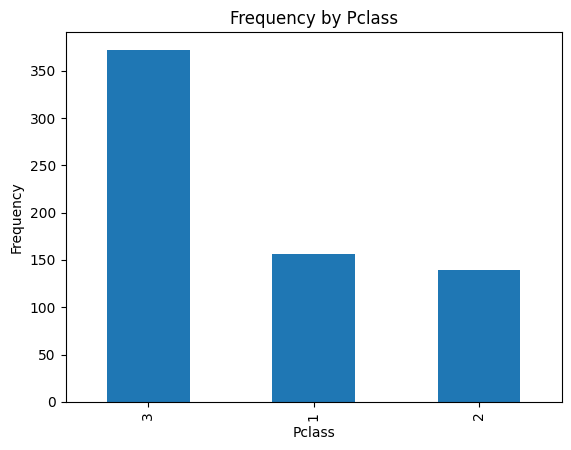

In [17]:
# Exploring Pclass
generate_frequency_plot('Pclass')

In [18]:
# Survival rate by within Pclass + aggregate
survival_rate_by_pclass = merged_train.groupby(['Pclass'])['Survived'].agg(['sum','count']).reset_index()
survival_rate_by_pclass['Survived_Percentage_Pclass'] = 100.00 * (survival_rate_by_pclass['sum'] / survival_rate_by_pclass['count'])
survival_rate_by_pclass['Survived_Percentage_Overall'] = 100.00 * (survival_rate_by_pclass['sum'] / survival_rate_by_pclass['sum'].sum())
survival_rate_by_pclass.head()

,Pclass,sum,count,Survived_Percentage_Pclass,Survived_Percentage_Overall
0,1,95,156,60.897436,38.617886
1,2,67,139,48.201439,27.235772
2,3,84,372,22.580645,34.146341


In [19]:
# Survival rate in Pclass by sex
survival_rate_by_pclass_sex = merged_train.groupby(['Pclass','Sex'])['Survived'].agg(['sum','count']).reset_index()
survival_rate_by_pclass_sex['Survived_Percentage_Pclass'] = 100.00 * (survival_rate_by_pclass_sex['sum'] / survival_rate_by_pclass_sex['count'])
survival_rate_by_pclass_sex['Survived_Percentage_Overall'] = 100.00 * (survival_rate_by_pclass_sex['sum'] / survival_rate_by_pclass_sex['count'].sum())
survival_rate_by_pclass_sex.head()

,Pclass,Sex,sum,count,Survived_Percentage_Pclass,Survived_Percentage_Overall
0,1,female,64,66,96.969697,9.595202
1,1,male,31,90,34.444444,4.647676
2,2,female,54,59,91.525424,8.095952
3,2,male,13,80,16.250000,1.949025
4,3,female,50,107,46.728972,7.496252


In [20]:
# Generate countplot based on column bins
def countplot_with_bins(bins:list, labels:list, column:str):
    merged_train[f'{column}_Bin'] = pd.cut(merged_train[f'{column}'], bins=bins, labels=labels, include_lowest=True)
    survived = merged_train[merged_train['Survived'] == 1]
    plt.title(f'Survival by {column}_Bin')
    plt.xlabel(f'{column}_Bin')
    plt.ylabel('Percent')
    sns.countplot(data=survived, x=f'{column}_Bin', hue='Survived', stat='percent')

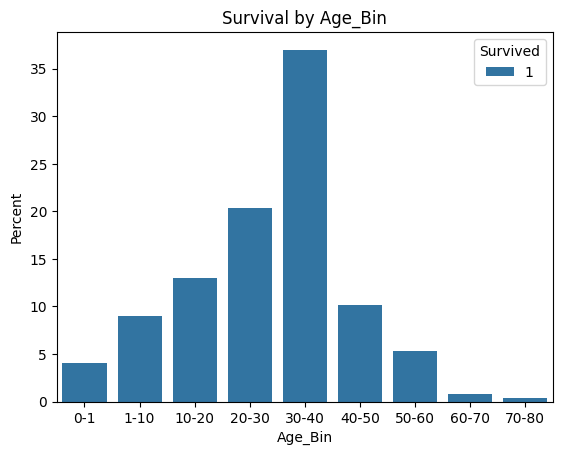

In [21]:
# Survival rate by age group
bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-1', '1-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
countplot_with_bins(bins=bins, labels=labels, column='Age')

In [22]:
# Exploring SibSp
merged_train['SibSp'].value_counts()

SibSp
0    449
1    171
2     16
3     13
4     11
8      4
5      3
Name: count, dtype: int64

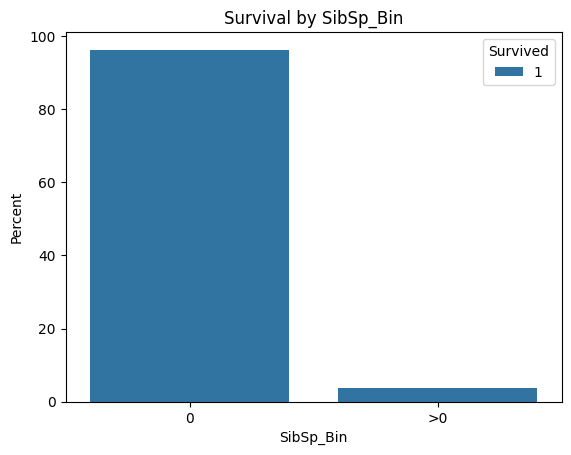

In [23]:
# Survival rate number of siblings 0 vs not 0
bins = [0, 1, float('inf')]
labels = ['0', '>0']
countplot_with_bins(bins=bins, labels=labels, column='SibSp')

In [24]:
# Exploring Parch
merged_train['Parch'].value_counts()

Parch
0    501
1     98
2     57
3      4
4      4
5      2
6      1
Name: count, dtype: int64

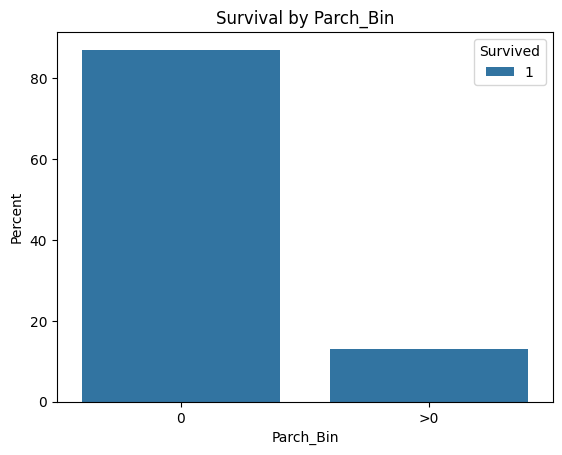

In [25]:
# Survival rate number of Parch 0 vs not 0
bins = [0, 1, float('inf')]
labels = ['0', '>0']
countplot_with_bins(bins=bins, labels=labels, column='Parch')

In [26]:
# Exploring Ticket values for survivors
survived = merged_train[merged_train['Survived'] == 1]
survived_ticket_counts = survived['Ticket'].value_counts()
survived_ticket_counts_greater_than_one = survived_ticket_counts[survived_ticket_counts > 1]
df = pd.DataFrame({'Ticket': survived_ticket_counts_greater_than_one.index,
'Count': survived_ticket_counts_greater_than_one.values})
df.head(100)


,Ticket,Count
0,113760,3
1,17421,3
2,PC 17757,3
3,364516,2
4,2668,2
5,113505,2
6,347077,2
7,11967,2
8,17474,2
9,PP 9549,2


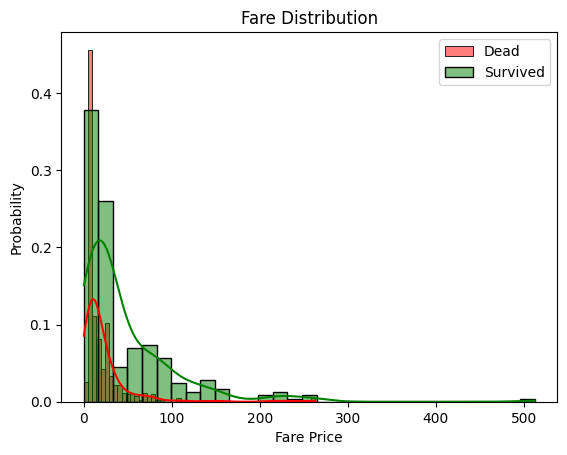

In [27]:
# Exploring fare prices
dead = merged_train[merged_train['Survived'] == 0]
survived = merged_train[merged_train['Survived'] == 1]
plt.title('Fare Distribution')
plt.xlabel('Fare Price')
plt.ylabel('Probability')
sns.histplot(dead['Fare'], color='red', label='Dead', kde=True, stat='probability')
sns.histplot(survived['Fare'], color='green', label='Survived', kde=True, stat='probability')
plt.legend()

In [28]:
# Summary Statistics for fare prices
print('Dead', dead['Fare'].describe(), sep='\n')
print('Survived', survived['Fare'].describe(), sep='\n')

Dead
count    421.000000
mean      22.387429
std       33.451746
min        0.000000
25%        7.854200
50%       10.500000
75%       26.000000
max      263.000000
Name: Fare, dtype: float64
Survived
count    246.000000
mean      47.092243
std       58.739037
min        0.000000
25%       12.475000
50%       26.000000
75%       65.000000
max      512.329200
Name: Fare, dtype: float64


Text(0, 0.5, 'Fare')

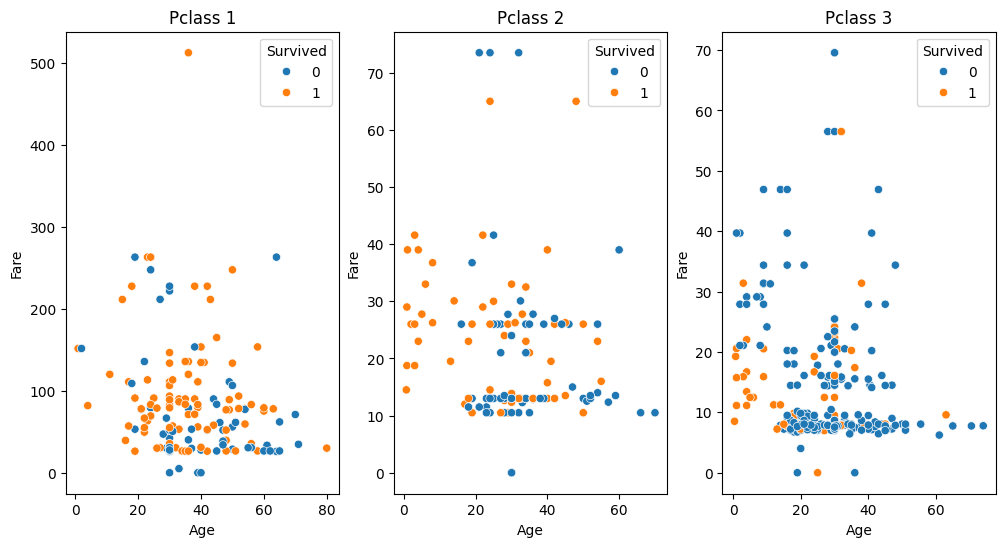

In [29]:
# Age vs Fare price by Pclass dead + survived
fig,axes = plt.subplots(1,3, figsize=(12,6))
sns.scatterplot(data=merged_train[merged_train['Pclass'] == 1], x='Age', y='Fare', hue='Survived', ax=axes[0])
axes[0].set_title('Pclass 1')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Fare')
sns.scatterplot(data=merged_train[merged_train['Pclass'] == 2], x='Age', y='Fare', hue='Survived', ax=axes[1])
axes[1].set_title('Pclass 2')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Fare')
sns.scatterplot(data=merged_train[merged_train['Pclass'] == 3], x='Age', y='Fare', hue='Survived', ax=axes[2])
axes[2].set_title('Pclass 3')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Fare')

<Axes: title={'center': 'Average Fare by Pclass with hue for Sex'}, xlabel='Pclass', ylabel='Average Fare'>

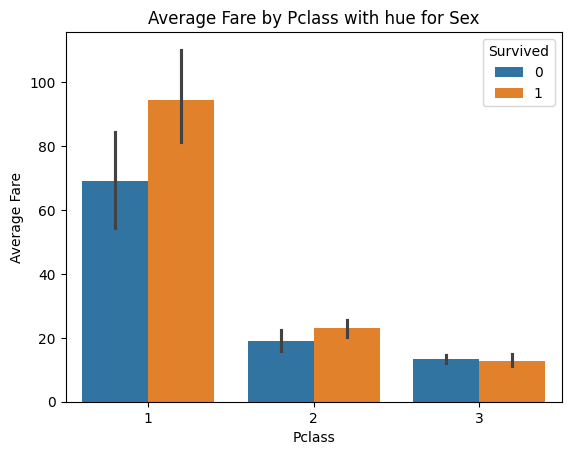

In [30]:
# Average fare price by Pclass
plt.title('Average Fare by Pclass with hue for Sex')
plt.xlabel('Pclass')
plt.ylabel('Average Fare')
sns.barplot(merged_train, x='Pclass', y='Fare', hue='Survived', estimator='mean')

In [31]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare
35,1,male,42.000000,1,0,113789,52.0000
46,3,male,30.013895,1,0,370371,15.5000
453,1,male,49.000000,1,0,17453,89.1042
291,1,female,19.000000,1,0,11967,91.0792
748,1,male,19.000000,1,0,113773,53.1000


In [32]:
# Feature Engineering
'''Functions for one hot encoding training and validation data'''
one_hot_encoder = OneHotEncoder(sparse_output=False)
def encode_column_train(encoder:OneHotEncoder, column:str, X:pd.DataFrame):
    encoded_column = encoder.fit_transform(X[[f'{column}']])
    return encoded_column

def encode_column_valid(encoder:OneHotEncoder, column:str, X:pd.DataFrame):
    encoded_column = encoder.transform(X[[f'{column}']])
    return encoded_column

def one_hot_encoding_train(encoder:OneHotEncoder, column:str, X:pd.DataFrame):
    encoded_column = encode_column_train(encoder, column, X)
    encoded_df = pd.DataFrame(encoded_column, index=X.index)
    encoded_df.columns = encoder.get_feature_names_out([f'{column}'])
    X_drop = X.drop(column, axis=1)
    X = pd.concat([X_drop, encoded_df], axis=1)
    return X

def one_hot_encoding_valid(encoder:OneHotEncoder, column:str, X:pd.DataFrame):
    encoded_column = encode_column_valid(encoder, column, X)
    encoded_df = pd.DataFrame(encoded_column, index=X.index)
    encoded_df.columns = encoder.get_feature_names_out([f'{column}'])
    X_drop = X.drop(column, axis=1)
    X = pd.concat([X_drop, encoded_df], axis=1)
    return X

In [33]:
'''Drop Ticket column'''
X_train = X_train.drop('Ticket', axis=1)
X_valid = X_valid.drop('Ticket', axis=1)

'''One hot encode Sex'''
X_train = one_hot_encoding_train(encoder=one_hot_encoder, column='Sex', X=X_train)
X_valid = one_hot_encoding_valid(encoder=one_hot_encoder, column='Sex', X=X_valid)

'''Create Age_Category column for age and one hot encode'''
bins = [0, 40, float('inf')]
labels = ['less_than_40', 'greater_than_or_equal_to_40']
X_train['Age_Category'] = pd.cut(X_train['Age'], bins=bins, labels=labels, include_lowest=True)
X_train = X_train.drop('Age', axis=1)
X_train = one_hot_encoding_train(encoder=one_hot_encoder, column='Age_Category', X=X_train)
X_valid['Age_Category'] = pd.cut(X_valid['Age'], bins=bins, labels=labels, include_lowest=True)
X_valid = X_valid.drop('Age', axis=1)
X_valid = one_hot_encoding_valid(encoder=one_hot_encoder, column='Age_Category', X=X_valid)

'''Create SibSp_Category column and one hot encode'''
bins = [0, 1, float('inf')]
labels = ['equal_to_0', 'greater_than_0']
X_train['SibSp_Category'] = pd.cut(X_train['SibSp'], bins=bins, labels=labels, include_lowest=True)
X_train = X_train.drop('SibSp', axis=1)
X_train = one_hot_encoding_train(encoder=one_hot_encoder, column='SibSp_Category', X=X_train)
X_valid['SibSp_Category'] = pd.cut(X_valid['SibSp'], bins=bins, labels=labels, include_lowest=True)
X_valid = X_valid.drop('SibSp', axis=1)
X_valid = one_hot_encoding_train(encoder=one_hot_encoder, column='SibSp_Category', X=X_valid)

'''Create Parch_Category column and one hot encode'''
bins = [0, 1, float('inf')]
labels = ['equal_to_0', 'greater_than_0']
X_train['Parch_Category'] = pd.cut(X_train['Parch'], bins=bins, labels=labels, include_lowest=True)
X_train = X_train.drop('Parch', axis=1)
X_train = one_hot_encoding_train(encoder=one_hot_encoder, column='Parch_Category', X=X_train)
X_valid['Parch_Category'] = pd.cut(X_valid['Parch'], bins=bins, labels=labels, include_lowest=True)
X_valid = X_valid.drop('Parch', axis=1)
X_valid = one_hot_encoding_valid(encoder=one_hot_encoder, column='Parch_Category', X=X_valid)

In [34]:
X_train.head()

,Pclass,Fare,Sex_female,Sex_male,Age_Category_greater_than_or_equal_to_40,Age_Category_less_than_40,SibSp_Category_equal_to_0,SibSp_Category_greater_than_0,Parch_Category_equal_to_0,Parch_Category_greater_than_0
35,1,52.0000,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
46,3,15.5000,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
453,1,89.1042,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
291,1,91.0792,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
748,1,53.1000,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [35]:
# Calculate MI scores with new features
calc_mi_scores(X_train, y_train)

Sex_female                                  0.162945
Sex_male                                    0.147101
Fare                                        0.129795
Pclass                                      0.056938
Parch_Category_greater_than_0               0.009321
SibSp_Category_equal_to_0                   0.009166
Parch_Category_equal_to_0                   0.008365
Age_Category_greater_than_or_equal_to_40    0.004706
Age_Category_less_than_40                   0.000000
SibSp_Category_greater_than_0               0.000000
Name: MI Scores, dtype: float64

Epoch 1/1000
2/2 [==============================] - 1s 193ms/step - loss: 1.3960 - binary_accuracy: 0.3688 - val_loss: 0.7949 - val_binary_accuracy: 0.4234
Epoch 2/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.8259 - binary_accuracy: 0.3958 - val_loss: 0.8690 - val_binary_accuracy: 0.5631
Epoch 3/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.8193 - binary_accuracy: 0.6177 - val_loss: 0.9727 - val_binary_accuracy: 0.5766
Epoch 4/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.8432 - binary_accuracy: 0.6312 - val_loss: 0.7293 - val_binary_accuracy: 0.5766
Epoch 5/1000
2/2 [==============================] - 0s 44ms/step - loss: 0.6722 - binary_accuracy: 0.6387 - val_loss: 0.6342 - val_binary_accuracy: 0.6667
Epoch 6/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.6438 - binary_accuracy: 0.6942 - val_loss: 0.6559 - val_binary_accuracy: 0.6396
Epoch 7/1000
2/2 [==============================] - 0s 36ms/step - lo

<Axes: title={'center': 'Accuracy'}>

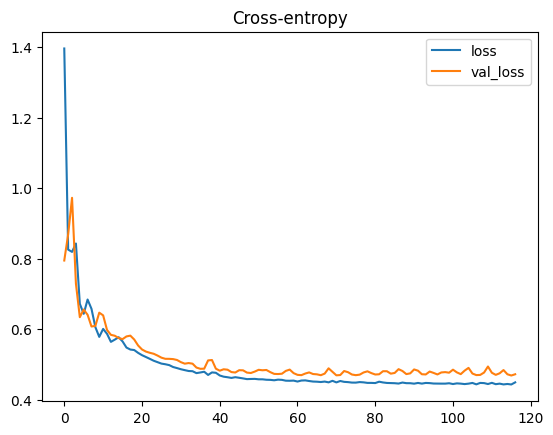

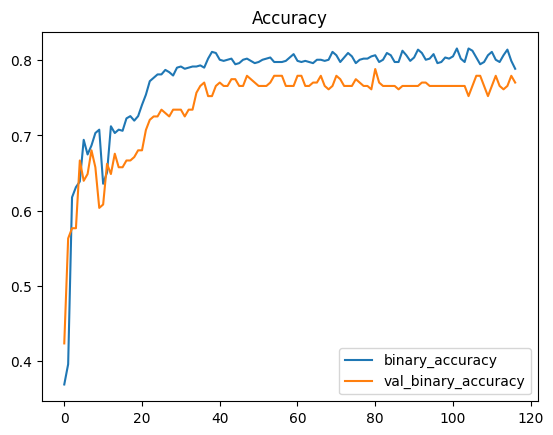

In [163]:
# Train + Fit model using Deep Learning
model = keras.Sequential([
    layers.Dense(400, activation='relu', input_shape=[10]),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['binary_accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=50,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size=524,
    epochs=1000,
    callbacks=[early_stopping]
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [ ]:
'''# Train + fit model
''' Use GridSearchCV to find best parameters'''
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_features': ['sqrt','log2', None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [None, 10, 20]
}
random_forest_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=random_forest_classifier, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print('Best params: ', best_params)
print('Best score: ', best_score)

'''Train + fit model using best estimators'''
best_estimator = grid_search.best_estimator_
best_estimator.fit(X_train, y_train)
test_accuracy = best_estimator.score(X_valid, y_valid)
print('Test set accuracy: ', test_accuracy)'''

Best params:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best score:  0.8111035730438715
Test set accuracy:  0.8018018018018018
